# Computer Vision SS 2021
## Exercise Sheet 3: Image Center, Edges, Keypoints
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. Kimberley Lühring
2. Björn Keohane
3. Frederic Stichler 
4. Till Strunk
5. Christian Grundman


In [ ]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation

%matplotlib inline

## Exercise 3.1
### Finding the Image Center
Camera calibration refers to the process of computing the intrinsic and extrinsic parameters of the camera. It is a necessary step in many computer vision applications such as 3D scene reconstruction and recognition. One important intrinsic parameter is the image center. Print out the images `ueb311.jpg` and `ueb312.jpg` and estimate the image centers by using a ruler.

**Hint**: Make small printouts of the images to have enough space around them.

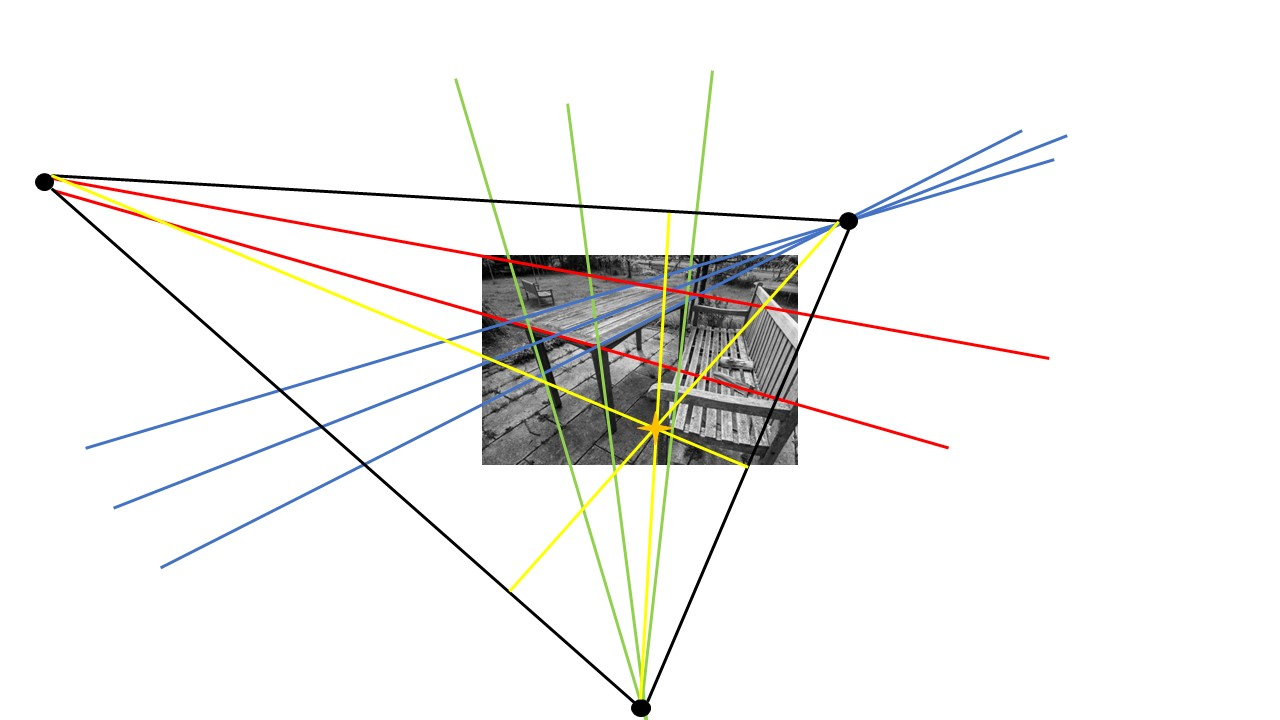

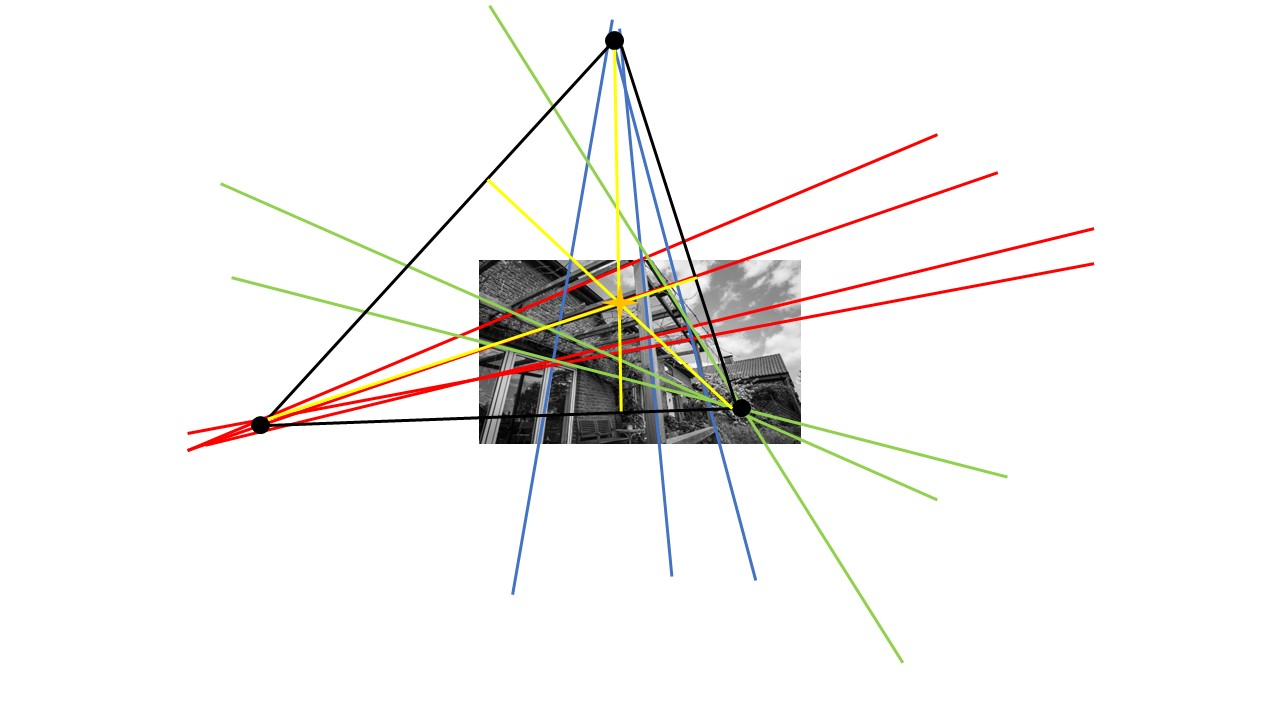

In [ ]:
def load_image_gray(image_path):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return image

In [ ]:
def load_image_gray_normalized(image_path):
    return load_image_gray(image_path).astype('float32')/255.
    

In [ ]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv.filter2D(image, -1, k_x)
    gradient_y = cv.filter2D(image, -1, k_y)

    return gradient_x, gradient_y


## Exercise 3.2.1
### Edge Detection
Open the image `ueb32.jpg` in Python and show the image gradients $d_x$ and $d_y$. Compute the magnitude of gradients image and apply a threshold to retain only the edges of the object. For those edges, compute and show the gradient angle image (`np.arctan2`). How can you tell the angle of the gradient from looking only at the gradients?

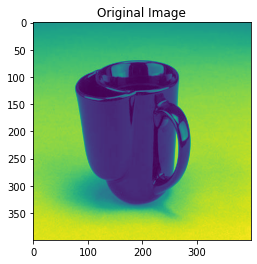

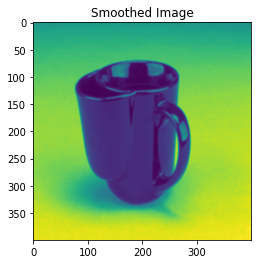

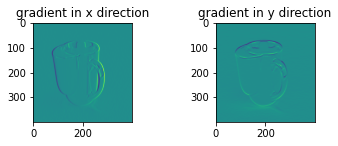

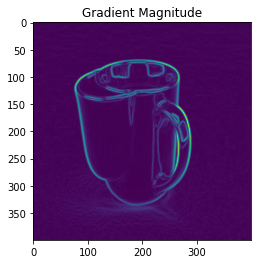

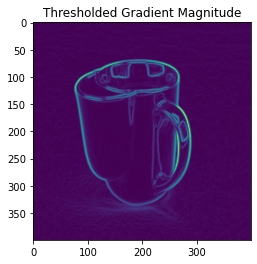

<function matplotlib.pyplot.show>

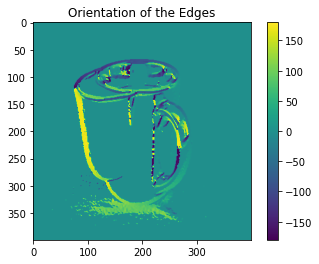

In [ ]:
# load image
ueb32 = load_image_gray_normalized('/content/cs4250/data/exercise_3/ueb32.jpg')
plt.imshow(ueb32)
plt.title('Original Image')
plt.show()

# smooth image
ueb32_smoothed = cv.GaussianBlur(ueb32,(5,5),0)
plt.imshow(ueb32_smoothed)
plt.title('Smoothed Image')
plt.show()

# compute and show gradient images 
x_grad, y_grad = gradient(ueb32_smoothed)

# make images comparable
vmin = np.min(np.concatenate((x_grad, y_grad))) 
vmax = np.max(np.concatenate((x_grad, y_grad))) 

plt.subplot(221)
plt.imshow(x_grad, vmin=vmin, vmax=vmax)
plt.title('gradient in x direction')
plt.subplot(222)
plt.imshow(y_grad, vmin=vmin, vmax=vmax)
plt.title('gradient in y direction')
plt.show()

# compute gradient magnitude
gm = np.hypot(x_grad,y_grad)  # equal to: sqrt(x_grad**2 + y_grad**2)
plt.imshow(gm)
plt.title('Gradient Magnitude')
plt.show()

threshold = 0.1  # should be between [0, 1] 

#gm_thresh
plt.imshow(gm)
plt.title('Thresholded Gradient Magnitude')
plt.show()

# compute an angle image that should be in range [-180,+180]
orien = np.arctan2(y_grad, x_grad)
orien[gm < threshold] = 0
orien = np.degrees(orien)

# show angles only for real edges
plt.imshow(orien)
plt.colorbar()
plt.title('Orientation of the Edges')
plt.show

# How can you tell the angle of the gradient from looking only at the gradients?
# Because one has the derivation into x and y direction and depending on the ratio, the direction is as follows?

In [ ]:
print(np.amin(ueb32))

0.0


## Exercise 3.2.2
### Canny Edge Detector
Open the image `ueb32.jpg` in Python and use the OpenCV Canny algorithm to find the edges in the image.
Compare the result with the magnitude of gradient image. Display both results side by side using `plt.subplots`.
Comment on how the two results differ and why.

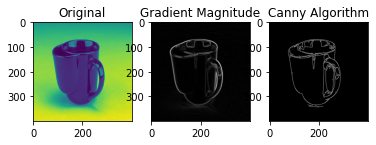

In [ ]:
# load image
ueb32_new = load_image_gray('/content/cs4250/data/exercise_3/ueb32.jpg')

# compute magnitude of gradient image
# from variable "gm" in the first section

# apply canny
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html
edges = cv.Canny(ueb32_new,50,100)

# compare results
plt.subplot(131)
plt.imshow(ueb32_new)
plt.title('Original')
plt.subplot(132)
plt.imshow(gm, cmap='gray')
plt.title('Gradient Magnitude')
plt.subplot(133)
plt.imshow(edges, cmap='gray')
plt.title('Canny Algorithm')
plt.show()

# Why do the results differ? 
# Canny edge detection is non directional and only considers higher contrast. On
# initial judgement this makes the Canny method "better". However there are 
# applications where the Canny algorithm does not function as well. If the 
# gradient angle is necessary or if lighter edges or contrasts are needed for
# edge detection, then Canny is not preffered. These are perhaps a minority of 
# cases.

## Exercise 3.3
### Key Point Detection
Implement the following key-point detectors:
* local maxima of $K$
* local maxima of $K$ − $\alpha$ $H^2$, with $\alpha$ as weighting parameter

The function is supposed to return images of the same size as the input, where the pixels contain $K$ or $K$ − $\alpha$ $H^2$.

$K$ and $H$ should be the invariants of the structure tensor $J$ (see script).
Evaluate the detectors above on two kinds of test images: (i) the synthetic image `ueb331.npy`, (ii) the
picture `ueb332.jpg`.

Comment your results with a focus on
1. the localization of the key points
2. the influence of the $H$ term as controlled via the parameter $\alpha$.

**Question**: Why do you filter the image with a Gaussian kernel a second time? It is **not** about noise removal!

**Hint**: Use the provided functions `find_local_max` and `plot_marks`.

In [ ]:
def find_local_max(keypoints, thres=1e-6, k=3):
    kernel = np.ones((k, k))
    kernel[k//2, k//2] = 0
    local_max = keypoints > thres + dilation(keypoints, kernel)

    return local_max

In [ ]:
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)

    ax.plot(row, col, 'r.')

In [ ]:
def key_points_structure(image, alpha, sigma=.1):
    pass
    # image parameters

    # 0. filter with Gaussian kernel with sigma
    
    # 1. partial derivatives
    x_grad, y_grad = gradient(image)

    # 2. product images
    I_x = x_grad * x_grad
    I_y = y_grad * y_grad
    I_xy = x_grad * y_grad

    # 3. filter with gaussian kernel with sigma = 1
    I_x = cv.GaussianBlur(I_x, (3, 3), 0)
    I_y = cv.GaussianBlur(I_y, (3, 3), 0)
    I_xy = cv.GaussianBlur(I_xy, (3, 3), 0)

    # 4. compute invarians for J
    H = I_x + I_y
    K = I_x * I_y - I_xy * I_xy

    # return K, K_minus_H
    return K, K - alpha * H * H
    

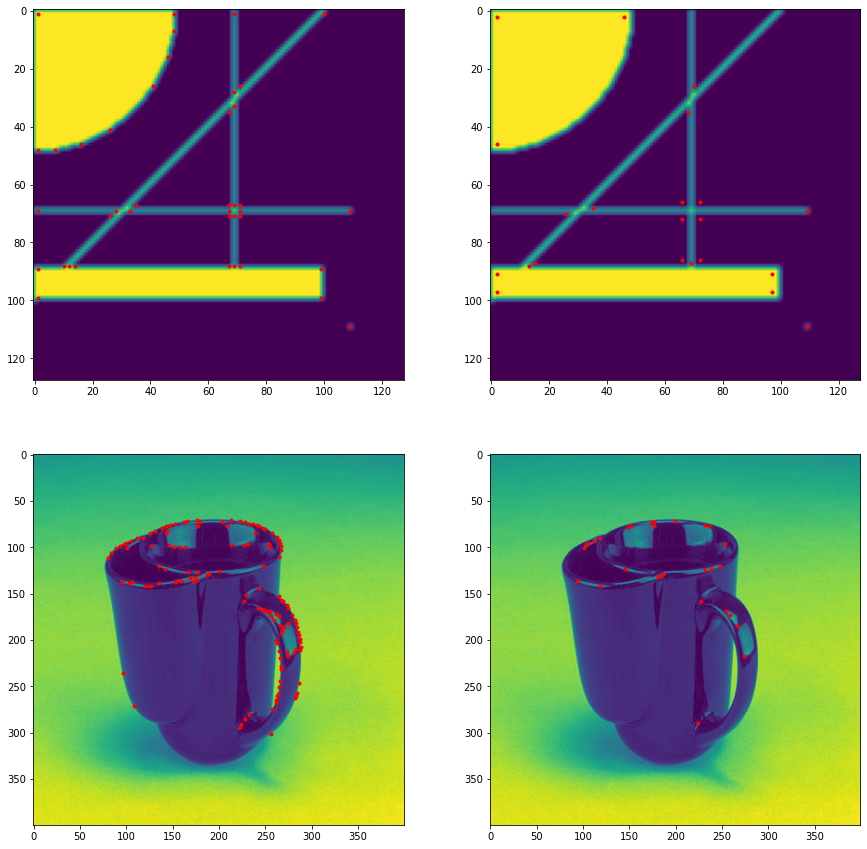

In [ ]:
# define alpha, sigma, and k
alpha = 0.2

# load images
ueb331 = np.load('/content/cs4250/data/exercise_3/ueb331.npy')
ueb332 = load_image_gray_normalized('/content/cs4250/data/exercise_3/ueb332.jpg')

# extract keypoints
keypoints_K, keypoints_K_minus_H = key_points_structure(ueb331, alpha)
keypoints_K_2, keypoints_K_minus_H_2 = key_points_structure(ueb332, alpha)

# show found keypoints (K, K_minus_H) for both images
_, ax = plt.subplots(2, 2, figsize=(15, 15))
local_max = find_local_max(keypoints_K)
ax[0][0].imshow(ueb331)
plot_marks(local_max, ax[0][0])

local_max = find_local_max(keypoints_K_minus_H)
ax[0][1].imshow(ueb331)
plot_marks(local_max, ax[0][1])

local_max = find_local_max(keypoints_K_2)
ax[1][0].imshow(ueb332)
plot_marks(local_max, ax[1][0])

local_max = find_local_max(keypoints_K_minus_H_2)
ax[1][1].imshow(ueb332)
plot_marks(local_max, ax[1][1])

# Questions
# Localization of the key points:
# They are always at the edges/where edges meet or at points with lots of 
# information.

# Influence of the H term under alpha
# If alpha is chosen large H has a bigger influence...

# Why filtering wih a gaussian kernel making local averages (as mentioned in the 
# lecture)?
# The guassian kernel creates local maxima and minima, where all points 
# neighboring such a point rise or fall. This means that this filter creates
# points where there is now higher path to the absolute maximum or lower path to 
# the absolute minimum.